In [2]:
try:
    from importlib import reload
except:
    pass

# %matplotlib inline
%matplotlib notebook

from matplotlib import pyplot as plt

import os
import numpy as np

from collections import OrderedDict
from astropy.table import Table

import pycoco as pcc

In [3]:
import json
import pandas as pd
import numpy as np

import pycoco as pcc
import pyCoCo as pccsim

from astropy.cosmology import LambdaCDM
from scipy.interpolate import InterpolatedUnivariateSpline

import lsst_tools as lsstt
from lcsim.simlib import SIMLIBReader
from lcsim.lcsim import LCSim
from datetime import datetime

ModuleNotFoundError: No module named 'pyCoCo'

In [3]:
snname = "SN1998bw"

sn = pcc.classes.SNClass(snname)
print(sn.name)
sn.load_phot(verbose = True)

sn.load_list("/Users/berto/Code/CoCo/lists/"+snname+".list")
sn.load_spec()
sn.get_lcfit("/Users/berto/Code/CoCo/recon/"+snname+".dat")

sn.check_overlaps()

SN1998bw
/Users/berto/Code/CoCo/data/lc/SN1998bw.dat


<IPython.core.display.Javascript object>


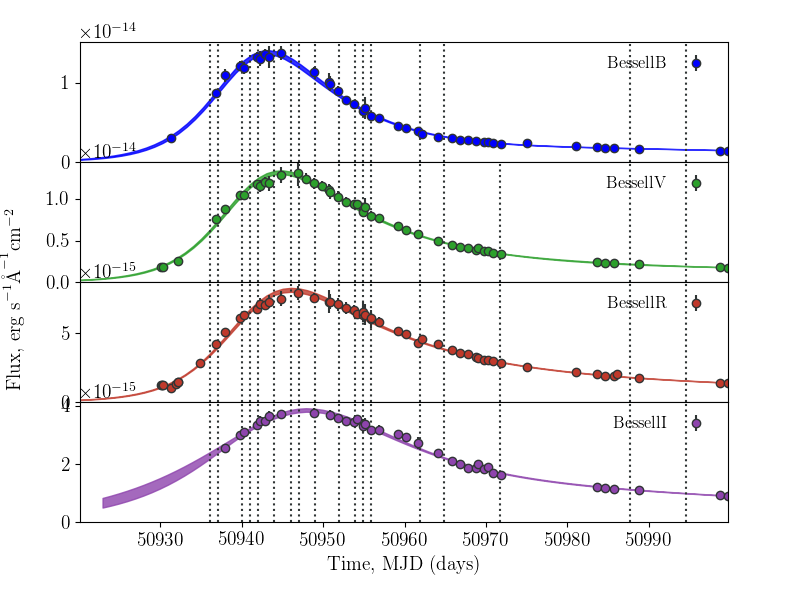

In [4]:
sn.plot_lc()

In [7]:
yaxis_lim_multiplier=1.1
verbose=False
lw=2.5
markersize=60.0
xminorticks=5.
yminorticks=0.5

pcc.utils.setup_plot_defaults()

params_dict = OrderedDict()

fltPath = b"/Users/berto/Code/CoCo/data/filters"
rootPath = b"/Users/berto/Code/CoCo"

coco = pccsim.pyCoCo(fltPath, rootPath)

mjdmax = pcc.utils.get_mjdmax(sn, "BessellB")
mjdmax_to_sim = 0

path_to_filter = os.path.join(pcc.defaults._default_filter_dir_path,"BessellB.dat")  
BessellB = pcc.classes.FilterClass()
BessellB.read_filter_file(path_to_filter)
BessellB.calculate_AB_zp()

lcs = LCSim()

info = pcc.classes.InfoClass()
info.load()

mjd_list = np.arange(0.,95,0.1)-30.
mjd_to_sim = np.array([])
filters_to_sim = []

for mjd in mjd_list:
    filters_to_sim = np.append(filters_to_sim, lsstt.utils.b(BessellB.filter_name))
    mjd_to_sim = np.append(mjd_to_sim, mjd)

###
colourmap = plt.get_cmap("plasma")
fig = plt.figure(figsize=[12, 8])

fig.subplots_adjust(left = 0.09, bottom = 0.13, top = 0.99,
                    right = 0.97, hspace=0, wspace = 0)
ax1 = fig.add_subplot(111)
xaxis_label_string = r"$\textnormal{Phase, }\tau$"
yaxis_label_string = r"$\textnormal{Apparent B-band Magnitude, }m^{\textnormal{AB}}_{B}$"

z_sim = info.get_sn_info("SN1998bw")["z_distmod"]
z_list = [z_sim[0], 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
# z_list = np.arange(0.0001,0.2,0.001)

log_z_list = np.log10(z_list)
z_cmap = log_z_list - np.nanmin(log_z_list)

z_cmap = z_cmap/np.nanmax(z_cmap)
for i, z_to_sim in enumerate(z_list):
    if verbose: print("running z =", z_to_sim)
    flux, flux_err = coco.simulate(b"SN1998bw",
                                   z_to_sim, 0.0, 0.0, 0.0, 3.1,
                                   mjdmax_to_sim, mjd_to_sim,
                                   filters_to_sim)
    specphot = coco.spec_photometry(b"SN1998bw", 
                 z_to_sim, b"BessellB")
    params = np.array(coco.get_fit_params()[b"BessellB"])
    if i == 0:
        params_array = params
    else:
        params_array = np.vstack((params_array, params))
    params_dict[str(z_to_sim)] = params
    ###

    sn_sim = pcc.classes.SNClass("SN1998bw")
    sn_sim.load_phot(phot_table = pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim))

    sp = pcc.classes.PhotometryClass()
    sp.load_table(pcc.utils.specphot_out_to_ap_table(specphot, mjdmax_to_sim, "BessellB"))
    sp.phot["m_AB"] = -2.5 * np.log10(sp.phot["flux"]) - BessellB.zp_AB

    time_dilation = 1.+z_to_sim

    mag = -2.5 * np.log10(flux) - BessellB.zp_AB
#         ax1.scatter(sp.phot["MJD"], sp.phot["flux"])
    if i == 0:
        ax1.scatter(sp.phot["MJD"]*time_dilation, sp.phot["m_AB"], color = pcc.colours.hex["BessellB"], 
                    label = r"$\textnormal{Bessell B}$", edgecolors = pcc.colours.hex["batman"], 
                    s=markersize)
        ax1.plot(mjd_to_sim*time_dilation, mag, color = colourmap(z_cmap[i]), label = r"$"+str(round(z_to_sim, 4))+"$",
                 lw=lw, zorder=0)
    else:
        ax1.scatter(sp.phot["MJD"]*time_dilation, sp.phot["m_AB"], color = pcc.colours.hex["BessellB"],
                    label = None, edgecolors = pcc.colours.hex["batman"], s=markersize)
        ax1.plot(mjd_to_sim*time_dilation, mag, color = colourmap(z_cmap[i]), label = r"$"+str(z_to_sim)+"$",
                 lw=lw, zorder=0)

#         ax1.plot(mjd_to_sim, mag, color = "black", label = r"$"+str(z_to_sim)+"$")
    if verbose: print(r"$"+str(z_to_sim)+"$")
#         ax1.plot(mjd_to_sim, mag, color = colourmap(z_to_sim), label = str(z_to_sim))

#     ax1.set_ylim(np.nanmin(sp.phot["flux"]), np.nanmax(sp.phot["flux"])*yaxis_lim_multiplier)
#     ax1.set_ylim(0, 4.5e-15)
ax1.set_ylim(25.5, 13.)
ax1.set_xlim(-32.5, 82.5)

xminorLocator = MultipleLocator(xminorticks)
ax1.xaxis.set_minor_locator(xminorLocator)
yminorLocator = MultipleLocator(yminorticks)
ax1.yaxis.set_minor_locator(yminorLocator)

ax1.set_xlabel(xaxis_label_string)
ax1.set_ylabel(yaxis_label_string)
ax1.legend(loc = 1, scatterpoints = 1,
          numpoints = 1, frameon = False, fontsize = 14)
plt.show

NameError: name 'pccsim' is not defined